# Fitting a PDF for assessing uncertainty

In [36]:
import numpy as np
import math
from scipy.special import gamma, gammainc, betainc
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, curve_fit
import pandas as pd
from gekko import GEKKO
from scipy.stats import norm
import sympy as sp

## Data

In [2]:
data = pd.read_csv('data/uncertainty_ranges.csv',names = ['year','tech','mu','perc_5','perc_95'], header=0) 

In [3]:
data_electrolysis = pd.read_csv('data/uncertainty_ranges_electrolysis.csv', names = ['year','tech','mu','perc_25','perc_75'], header=0) 

In [4]:
data_other = pd.read_csv('data/uncertainty_ranges_us.csv', names = ['year','tech','mu','perc_20','perc_80'], header=0) 

In [5]:
data.shape

(88, 5)

In [6]:
data.head()

,year,tech,mu,perc_5,perc_95
0,2010,UTILITY_PV,4593,3303,7693
1,2011,UTILITY_PV,3890,2531,7550
2,2012,UTILITY_PV,2933,2024,6476
3,2013,UTILITY_PV,2570,1650,5202
4,2014,UTILITY_PV,2323,1381,5125


In [7]:
data_electrolysis.head()

,year,tech,mu,perc_25,perc_75
0,2013,ALK,1302,1212,1480
1,2014,ALK,1039,883,1160
2,2015,ALK,1203,983,1459
3,2016,ALK,1038,916,1156
4,2017,ALK,944,844,1000


In [8]:
data_other.head()

,year,tech,mu,perc_20,perc_80
0,2020,RES_PV,2443,1917,2954
1,2019,RES_PV,2507,2024,3004
2,2018,RES_PV,2705,2210,3355
3,2017,RES_PV,3027,2452,3787
4,2016,RES_PV,3103,2602,3831


## Uncertainty viz

In [9]:
def graph_uncertainty(df, tech, percentile):
    dat = df[df.tech == tech]
    plt.plot(dat.year, dat.mu,'b-',label='mean')
    plt.fill_between(dat.year,dat["perc_"+str(percentile)],dat["perc_"+str(100-percentile)],alpha=0.2,label=str(percentile)+'th and '+str(100-percentile)+'th percentile')
    plt.xlabel('Year')
    plt.ylabel('Cost [USD_2018/kW]')
    plt.title(tech)
    plt.legend()
    plt.show()

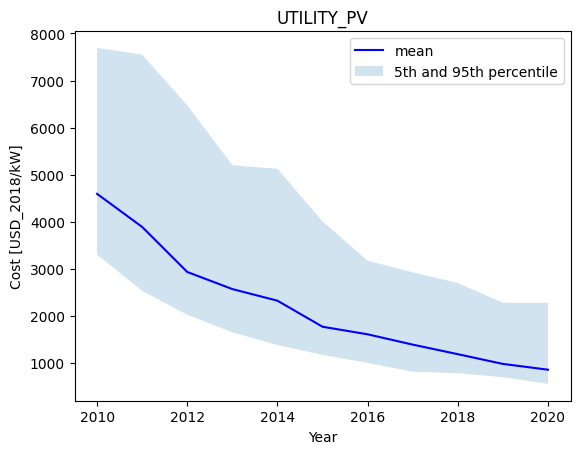

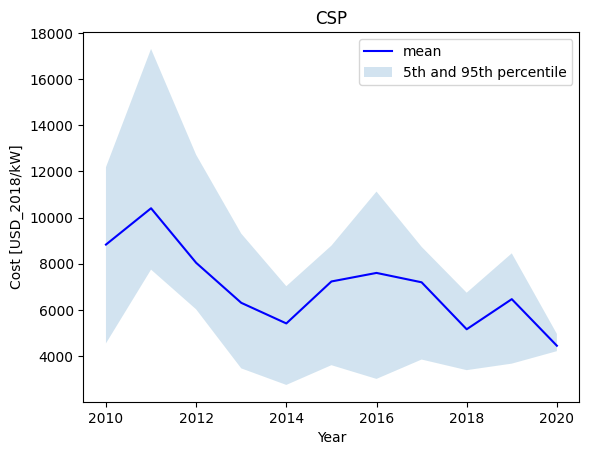

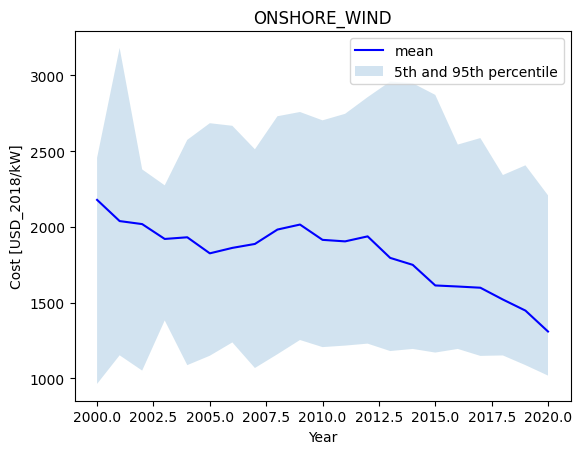

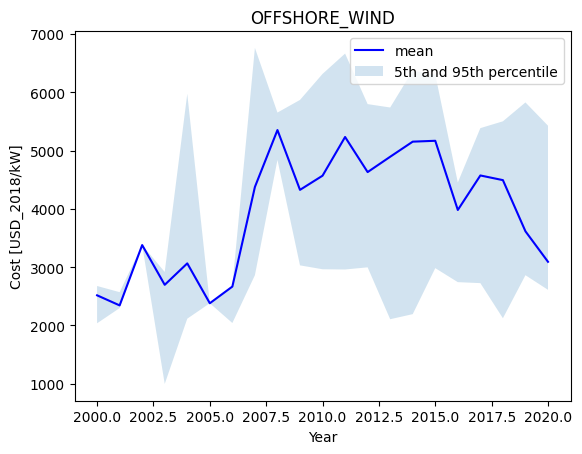

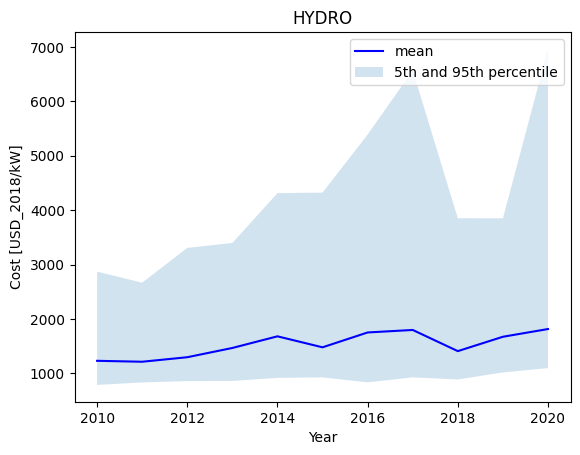

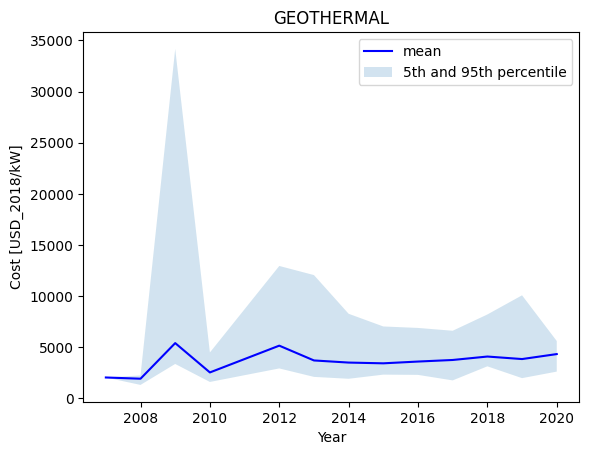

In [10]:
for tech in list(data.tech.unique()):
    graph_uncertainty(data, tech, 5)

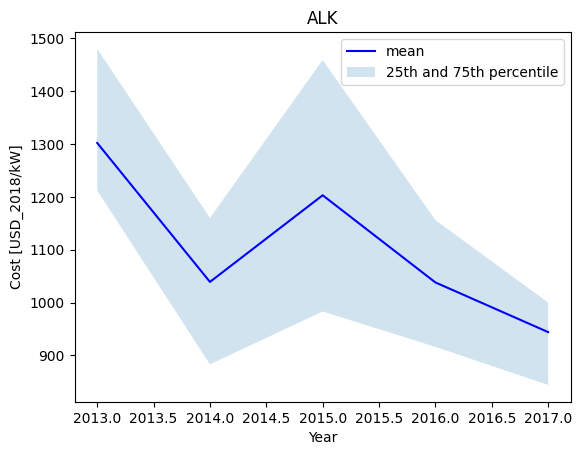

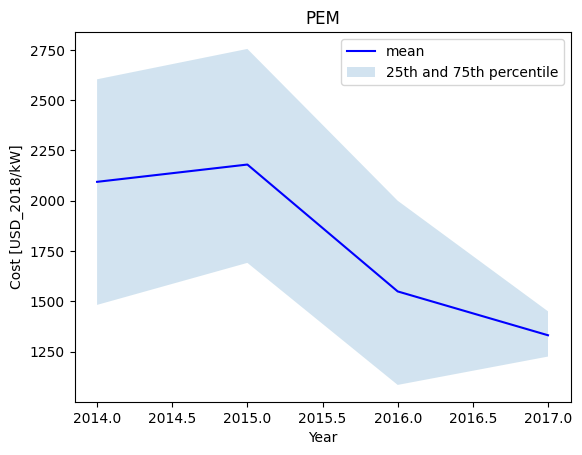

In [11]:
for tech in list(data_electrolysis.tech.unique()):
    graph_uncertainty(data_electrolysis, tech, 25)

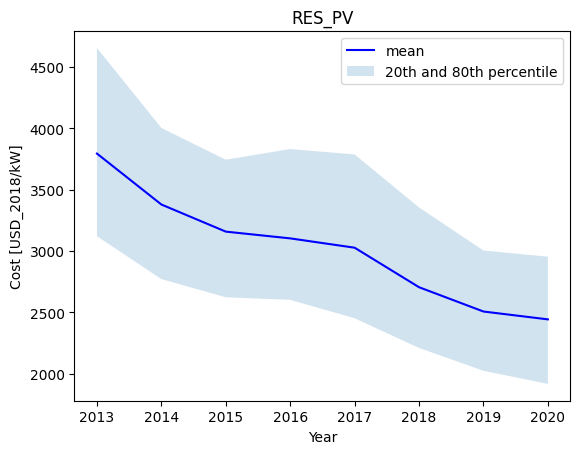

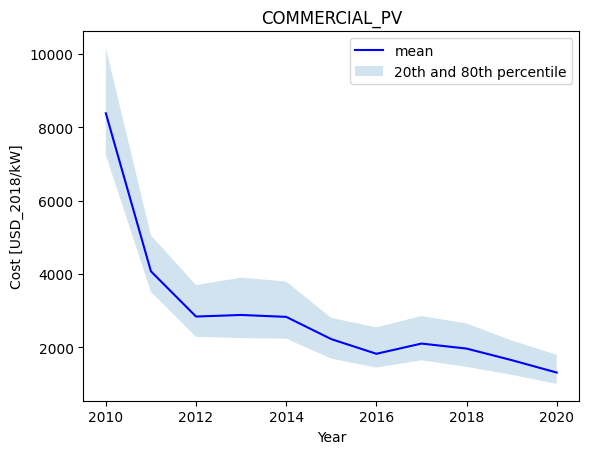

In [12]:
for tech in list(data_other.tech.unique()):
    graph_uncertainty(data_other, tech, 20)

## Triangular PDF fitting

In [13]:
def pdf_triang(x,a,b,c):
    if (x < a):
        return 0
    elif (a <= x < c):
        return(2*(x-a) / ((b-a)*(c-a)))
    elif (x==c):
        return(2 / (b-a))
    elif (c < x <= b):
        return(2*(b-x) / ((b-a)*(b-c)))
    else:
        return 0

In [14]:
def cdf_triang_sup_c(x,a,b,c):
    return(1 - (b-x)**2 / ((b-a)*(b-c)))

In [15]:
def cdf_triang_inf_c(x,a,b,c):
    return((x-a)**2 / ((b-a)*(c-a)))

In [16]:
def cdf_triang(x,a,b,c):
    if (x <= a):
        return 0
    elif (a < x <= c):
        return cdf_triang_inf_c(x,a,b,c)
    elif (c < x < b):
        return cdf_triang_sup_c(x,a,b,c)
    else: 
        return 1

In [144]:
def num_solve_triang(x0, x1, x2, p0, p1):
    '''Numerical solving of the non-linear system of equations for triangular CDF'''
    x_low = float(x0)
    x_exp = float(x1)
    x_high = float(x2)
    perc_low = float(p0)
    perc_high = float(p1)
    a = sp.symbols("a")
    b = sp.symbols("b")
    c = sp.symbols("c")
    equations = [(x_low-a)**2 / ((b-a)*(c-a)) - perc_low,
                 (1 - (b-x_high)**2 / ((b-a)*(b-c))) - perc_high,
                 (a+b+c)/3 - x_exp]
                 #c - x_exp]
    root = sp.nsolve(equations, [a, b, c], [x_low-100, x_high+100, x_exp])
    return([float(root[0]), float(root[1]), float(root[2])])

In [145]:
def results(df, percentile):
    a = []
    b = []
    c = []
    for i in range(df.shape[0]):
        if (float(df.loc[[i],:]["perc_"+str(percentile)]) == float(df.loc[[i],:].mu) == float(df.loc[[i],:]["perc_"+str(100-percentile)])):
            a.append(float(df.loc[[i],:]["perc_"+str(percentile)].to_numpy()))
            b.append(float(df.loc[[i],:]["perc_"+str(100-percentile)].to_numpy()))
            c.append(float(df.loc[[i],:].mu.to_numpy()))

        else:
            #print(i,float(df.loc[[i],:].perc_05) , float(df.loc[[i],:].mu) , float(df.loc[[i],:].perc_95))
            root = num_solve_triang(x0=float(df.loc[[i],:]["perc_"+str(percentile)]), 
                                    x1=float(df.loc[[i],:].mu), 
                                    x2=float(df.loc[[i],:]["perc_"+str(100-percentile)]), 
                                    p0=percentile/100, p1=(100-percentile)/100)
            a.append(root[0])
            b.append(root[1])
            c.append(root[2])
    
    return(a, b, c)

In [ ]:
(a,b,c) = results(data, 5)
#data["triang_a"] = pd.Series(a)
#data["triang_b"] = pd.Series(b)
#data["triang_c"] = pd.Series(c)

In [20]:
(a,b,c) = results(data_electrolysis, 25)
data_electrolysis["triang_a"] = pd.Series(a)
data_electrolysis["triang_b"] = pd.Series(b)
data_electrolysis["triang_c"] = pd.Series(c)

In [21]:
(a,b,c) = results(data_other, 20)
data_other["triang_a"] = pd.Series(a)
data_other["triang_b"] = pd.Series(b)
data_other["triang_c"] = pd.Series(c)

## 3-parameter Weibull PDF fitting

In [128]:
def cdf_weibull(x,a,b,c): 
    return 1 - np.exp(-((x-c)/a)**b)

In [129]:
def pdf_weibull(x,a,b,c): 
    return (b/a)*(((x-c)/a)**(b-1))*np.exp(-((x-c)/a)**b)

In [130]:
def cdf_weibull_plot(x,a,b,c):
    if (x >= c):
        return 1 - np.exp(-((x-c)/a)**b)
    else:
        return 0

In [131]:
def pdf_weibull_plot(x,a,b,c): 
    if (x >= c):
        return (b/a)*(((x-c)/a)**(b-1))*np.exp(-((x-c)/a)**b)
    else:
        return 0

In [137]:
def plot_cdf_weibull(x,a,b,c):
    y = []
    for i in range(len(x)):
        y.append(cdf_weibull_plot(x[i],a,b,c))
    plt.plot(x, y, marker='', linestyle='solid', label="Weibull")

In [138]:
def plot_pdf_weibull(x,a,b,c):
    y = []
    for i in range(len(x)):
        y.append(pdf_weibull_plot(x[i],a,b,c))
    plt.plot(x, y, marker='', linestyle='solid', label="Weibull")

In [134]:
def num_solve_weibull(x0, x1, x2, p0, p1):
    
    if (x0 == x1 == x2):
        return(x0, x1, x2)
    
    counter = 0
    counter_lim = 3000
    
    guess = [3000, 0, 0]
    
    condition = False 
    
    while ((condition == False)): 
           #& (counter < counter_lim)):
        xm = np.array([x0, x1, x2])
        ym = np.array([p0, 0.50, p1])

        popt, pcov = curve_fit(cdf_weibull, xm, ym, p0 = guess, maxfev = 100000)

        condition = ((round(cdf_weibull(x=x0,a=popt[0],b=popt[1],c=popt[2]) - p0, 0) == 0) 
                     & (round(cdf_weibull(x=x1,a=popt[0],b=popt[1],c=popt[2]) - 0.50, 0) == 0)
                     & (round(cdf_weibull(x=x2,a=popt[0],b=popt[1],c=popt[2]) - p1, 0) == 0))
        
        guess[0] = np.random.randint(0, 3000)
        guess[1] = np.random.randint(0, 5)
        guess[2] = np.random.randint(-100, 100)
        
        counter+=1
    
    #if (counter == counter_lim):
    #    return(np.nan)
    
    else:
        return(popt)

In [135]:
def results_weibull(df, percentile):
    a = []
    b = []
    c = []
    
    for i in range(df.shape[0]):
        if (float(df.loc[[i],:]["perc_"+str(percentile)]) == float(df.loc[[i],:].mu) == float(df.loc[[i],:]["perc_"+str(100-percentile)])):
            a.append(float(df.loc[[i],:]["perc_"+str(percentile)].to_numpy()))
            b.append(float(df.loc[[i],:]["perc_"+str(100-percentile)].to_numpy()))
            c.append(float(df.loc[[i],:].mu.to_numpy()))

        else:
            #print(i,float(df.loc[[i],:].perc_05) , float(df.loc[[i],:].mu) , float(df.loc[[i],:].perc_95))
            root = num_solve_weibull(x0=float(df.loc[[i],:]["perc_"+str(percentile)]), 
                                    x1=float(df.loc[[i],:].mu), 
                                    x2=float(df.loc[[i],:]["perc_"+str(100-percentile)]), 
                                    p0=percentile/100, 
                                    p1=(100-percentile)/100)
            a.append(root[0])
            b.append(root[1])
            c.append(root[2])
    
    return(a, b, c)

In [136]:
num_solve_weibull(x0=3303, x1=4593, x2=7693, p0=0.05, p1=0.95)

C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\2135491085.py:2: RuntimeWarning: invalid value encountered in power
  return 1 - np.exp(-((x-c)/a)**b)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([1.97702490e+03, 1.30197245e+00, 3.10104514e+03])

In [64]:
(a,b,c) = results_weibull(data, 5)
data["weibull_a"] = pd.Series(a)
data["weibull_b"] = pd.Series(b)
data["weibull_c"] = pd.Series(c)

C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\2135491085.py:2: RuntimeWarning: invalid value encountered in power
  return 1 - np.exp(-((x-c)/a)**b)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warni

C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning

## PERT

In [65]:
def B(a,b):
    return(gamma(a)*gamma(b)/gamma(a+b))

In [66]:
def pdf_pert(x,a,b,c): # a < b < c, a:min, b:max
    alpha = 1 + 4*(c-a)/(b-a)
    beta = 1 + 4*(b-c)/(b-a)
    return((x-a)**(alpha-1) * (b-x)**(beta-1) / (B(alpha, beta)*(b-a)**(alpha+beta-1)))

In [67]:
def cdf_pert(x,a,b,c):
    alpha = 1 + 4*(c-a)/(b-a)
    beta = 1 + 4*(b-c)/(b-a)
    z = (x-a)/(b-a)
    return betainc(alpha, beta, z)

In [68]:
def num_solve_pert(x0, x1, x2, p0, p1):
    
    guess = [x0, x1, x2]
    
    condition = False 
    
    while (condition == False):
        xm = np.array([x0, x1, x2])
        ym = np.array([p0, 0.50, p1])

        popt, pcov = curve_fit(cdf_pert, xm, ym, p0 = guess, maxfev = 100000)

        condition = ((round(cdf_pert(x=x0,a=popt[0],b=popt[1],c=popt[2]) - p0, 2) == 0) 
                     & (round(cdf_pert(x=x1,a=popt[0],b=popt[1],c=popt[2]) - 0.50, 2) == 0)
                     & (round(cdf_pert(x=x2,a=popt[0],b=popt[1],c=popt[2]) - p1, 2) == 0))
        
        guess[0] = np.random.randint(0, x1)
        guess[2] = np.random.randint(x2, x2+200)
    
    return(popt)

In [69]:
def results_pert(df, percentile):
    a = []
    b = []
    c = []
    for i in range(df.shape[0]):
        if (float(df.loc[[i],:]["perc_"+str(percentile)]) == float(df.loc[[i],:].mu) == float(df.loc[[i],:]["perc_"+str(100-percentile)])):
            a.append(float(df.loc[[i],:]["perc_"+str(percentile)].to_numpy()))
            b.append(float(df.loc[[i],:]["perc_"+str(100-percentile)].to_numpy()))
            c.append(float(df.loc[[i],:].mu.to_numpy()))

        else:
            #print(i,float(df.loc[[i],:].perc_05) , float(df.loc[[i],:].mu) , float(df.loc[[i],:].perc_95))
            root = num_solve_pert(x0=float(df.loc[[i],:]["perc_"+str(percentile)]), 
                                    x1=float(df.loc[[i],:].mu), 
                                    x2=float(df.loc[[i],:]["perc_"+str(100-percentile)]), 
                                    p0=percentile/100, 
                                    p1=(100-percentile)/100)
            a.append(root[0])
            b.append(root[1])
            c.append(root[2])
    
    return(a, b, c)

In [70]:
(a,b,c) = results_pert(data, 5)
data["pert_a"] = pd.Series(a)
data["pert_b"] = pd.Series(b)
data["pert_c"] = pd.Series(c)

C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning

C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning

## Generalized gamma

In [81]:
def pdf_gamma(x,a,b,c):
    return (c/(a**b))*x**(b-1)*np.exp(-(x/a)**c)/gamma(b/c)

In [82]:
def cdf_gamma(x,a,b,c):
    return gammainc(b/c,(x/a)**c)

In [89]:
def num_solve_gamma(x0, x1, x2, p0, p1):
    
    guess = [x1, 5, 3]
    
    condition = False 
    
    while (condition == False):
        xm = np.array([x0, x1, x2])
        ym = np.array([p0, 0.50, p1])

        popt, pcov = curve_fit(cdf_gamma, xm, ym, p0 = guess, maxfev = 1000000)

        condition = ((round(cdf_gamma(x=x0,a=popt[0],b=popt[1],c=popt[2]) - p0, 0) == 0) 
                     & (round(cdf_gamma(x=x1,a=popt[0],b=popt[1],c=popt[2]) - 0.50, 0) == 0)
                     & (round(cdf_gamma(x=x2,a=popt[0],b=popt[1],c=popt[2]) - p1, 0) == 0))
        
        guess[1] = np.random.randint(1, 10)
        guess[2] = np.random.randint(1, 5)
    
    return(popt)

In [90]:
def results_gamma(df, percentile):
    a = []
    b = []
    c = []
    for i in range(df.shape[0]):
        if (float(df.loc[[i],:]["perc_"+str(percentile)]) == float(df.loc[[i],:].mu) == float(df.loc[[i],:]["perc_"+str(100-percentile)])):
            a.append(float(df.loc[[i],:]["perc_"+str(percentile)].to_numpy()))
            b.append(float(df.loc[[i],:]["perc_"+str(100-percentile)].to_numpy()))
            c.append(float(df.loc[[i],:].mu.to_numpy()))

        else:
            #print(i,float(df.loc[[i],:].perc_05) , float(df.loc[[i],:].mu) , float(df.loc[[i],:].perc_95))
            root = num_solve_gamma(x0=float(df.loc[[i],:]["perc_"+str(percentile)]), 
                                    x1=float(df.loc[[i],:].mu), 
                                    x2=float(df.loc[[i],:]["perc_"+str(100-percentile)]), 
                                    p0=percentile/100, 
                                    p1=(100-percentile)/100)
            a.append(root[0])
            b.append(root[1])
            c.append(root[2])
    
    return(a, b, c)

In [91]:
(a,b,c) = results_gamma(data, 5)
data["gamma_a"] = pd.Series(a)
data["gamma_b"] = pd.Series(b)
data["gamma_c"] = pd.Series(c)

C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minp

C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Us

C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: overflow encountered in divide
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\219400431.py:2: RuntimeWarning: invalid value encountered in power
  return gammainc(b/c,(x/a)**c)
C:\Users\matthieu.souttre\myenv\lib\site-packages\scipy\optimize\_minpack_

## Checking the results

In [92]:
data.isnull().sum()

year         0
tech         0
mu           0
perc_5       0
perc_95      0
triang_a     0
triang_b     0
triang_c     0
pert_a       0
pert_b       0
pert_c       0
weibull_a    0
weibull_b    0
weibull_c    0
gamma_a      0
gamma_b      0
gamma_c      0
dtype: int64

In [93]:
data.sample(10)

,year,tech,mu,perc_5,perc_95,triang_a,triang_b,triang_c,pert_a,pert_b,pert_c,weibull_a,weibull_b,weibull_c,gamma_a,gamma_b,gamma_c
70,2016,HYDRO,1753,836,5389,99.773590,6657.004033,1753.0,806.144302,-109.065317,13161.490127,1.443553e+03,0.944042,7.739084e+02,2.999881e-305,294.274451,0.014041
27,2005,ONSHORE_WIND,1826,1150,2685,812.869573,3056.547620,1826.0,873.411503,1716.748664,3417.359049,1.188754e+03,2.396080,8.058578e+02,3.399993e+02,12.094550,1.303604
68,2014,HYDRO,1682,918,4313,345.684000,5247.901792,1682.0,882.146768,436.609495,9530.493098,1.185980e+03,1.024647,8.526620e+02,2.399891e-305,431.180814,0.014528
25,2003,ONSHORE_WIND,1921,1383,2275,1160.455326,2462.841199,1921.0,816.817193,2031.856008,2378.844117,3.013051e+03,12.825158,-1.007163e+03,2.077293e+03,7.552815,10.049549
61,2018,OFFSHORE_WIND,4493,2124,5502,1229.001895,6137.225378,4493.0,-1556.360993,5347.914786,5620.664274,5.045982e+06,6960.808728,-5.041235e+06,5.597448e+03,3.153369,753.256066
52,2009,OFFSHORE_WIND,4326,3031,5869,2398.658949,6547.952656,4326.0,2438.040695,4178.249898,7078.377457,2.360796e+03,2.609855,2.274513e+03,7.194688e+02,18.170072,1.410288
46,2003,OFFSHORE_WIND,2697,997,2918,442.133102,3172.913129,2697.0,-3860.471254,3870.296233,2919.054238,8.023558e+05,5313.659209,-7.996034e+05,2.660564e+03,23.088145,14.960921
54,2011,OFFSHORE_WIND,5233,2960,6664,2029.434426,7435.612431,5233.0,453.019195,5741.817451,7049.076894,1.710759e+04,17.865059,-1.152719e+04,6.301805e+03,4.124022,9.746621
43,2000,OFFSHORE_WIND,2517,2037,2677,1884.934588,2616.627512,2517.0,1158.495229,2725.492947,2687.583164,5.721161e+05,5015.372579,-5.695588e+05,2.692320e+03,10.882342,141.801273
5,2015,UTILITY_PV,1770,1171,4009,703.994495,4795.795906,1770.0,1148.231117,659.461893,8650.730940,9.369875e+02,0.976304,1.126282e+03,1.668237e+03,7.058189,4.373298


In [ ]:
data_electrolysis.sample(5)

In [ ]:
data_other.sample(5)

## Summary graph

In [94]:
def plot_cdf_triang(x,a,b,c):
    y = []
    for i in range(len(x)):
        y.append(cdf_triang(x[i],a,b,c))
    plt.plot(x, y, marker='', linestyle='solid', label="Triangular")
    #plt.axvline(x=mean_triang(a,b,c), color='g', linestyle='dashed')
    plt.xlabel("x")
    plt.ylabel("CDF(x)")
    #plt.grid()
    plt.legend()
    plt.show()

In [105]:
def plot_pdf_triang(x,a,b,c):
    y = []
    for i in range(len(x)):
        y.append(pdf_triang(x[i],a,b,c))
    plt.plot(x, y, color='b', marker='', linestyle='solid', label="Triangular")
    #plt.axvline(x=mean_triang(a,b,c), color='g', linestyle='dashed')
    plt.xlabel("x")
    plt.ylabel("PDF(x)")
    #plt.grid()
    plt.savefig("triangular_PDF.pdf", format="pdf")
    plt.legend()
    plt.show()

In [106]:
data.head()

,year,tech,mu,perc_5,perc_95,triang_a,triang_b,triang_c,pert_a,pert_b,pert_c,weibull_a,weibull_b,weibull_c,gamma_a,gamma_b,gamma_c
0,2010,UTILITY_PV,4593,3303,7693,2482.755639,8859.276045,4593.0,3159.081982,3451.734793,12591.261248,1977.024903,1.301972,3101.045143,8.087790e-199,927.927000,0.022843
1,2011,UTILITY_PV,3890,2531,7550,1622.694400,8900.222956,3890.0,2414.570257,2415.715756,13805.888138,2082.239157,1.200266,2355.684749,9.361582e-231,639.437579,0.019344
2,2012,UTILITY_PV,2933,2024,6476,1300.431259,7714.271119,2933.0,1993.033954,1135.113556,13983.338336,3064.795502,6.944293,25.766817,2.763430e+03,7.908097,4.795012
3,2013,UTILITY_PV,2570,1650,5202,1018.142831,6163.506594,2570.0,1581.737292,1462.962677,9879.439825,2969.791106,6.560366,-238.425086,1.043331e-235,626.755625,0.018957
4,2014,UTILITY_PV,2323,1381,5125,722.393380,6142.371964,2323.0,1317.384683,1112.804393,10226.611678,2541.284663,5.128054,-42.992499,1.107454e-280,525.555801,0.015946


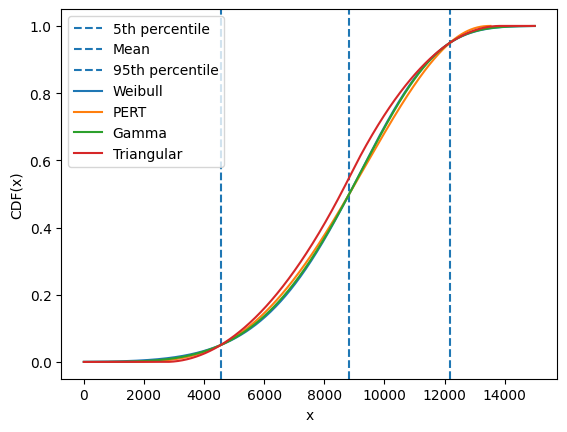

C:\Users\matthieu.souttre\AppData\Local\Temp\ipykernel_10864\61984392.py:4: RuntimeWarning: invalid value encountered in power
  return((x-a)**(alpha-1) * (c-x)**(beta-1) / (B(alpha, beta)*(c-a)**(alpha+beta-1)))


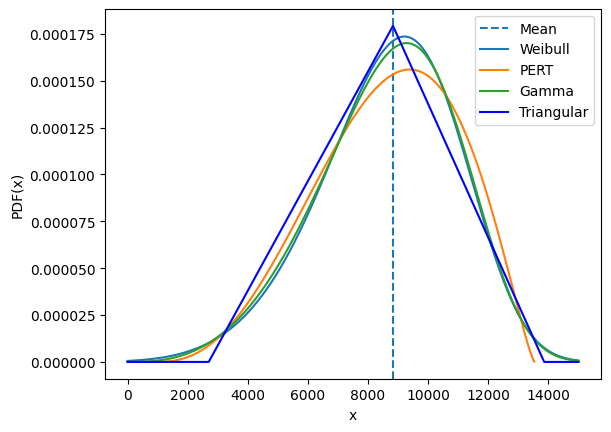

In [140]:
data_plot = data.sample(1)
#print(data_plot)
x = np.linspace(0,15000,1000)

plt.axvline(float(data_plot.perc_5), linestyle='dashed',label="5th percentile")
plt.axvline(float(data_plot.mu), linestyle='dashed',label="Mean")
plt.axvline(float(data_plot.perc_95), linestyle='dashed',label="95th percentile")

plot_cdf_weibull(x=x,a=float(data_plot.weibull_a),
                        b=float(data_plot.weibull_b),
                        c=float(data_plot.weibull_c))
plt.plot(x, cdf_pert(x=x,a=float(data_plot.pert_a),
                        b=float(data_plot.pert_b),
                        c=float(data_plot.pert_c)),label="PERT")
plt.plot(x, cdf_gamma(x=x,a=float(data_plot.gamma_a),
                        b=float(data_plot.gamma_b),
                        c=float(data_plot.gamma_c)),label="Gamma")
plot_cdf_triang(x, a=float(data_plot.triang_a),
                        b=float(data_plot.triang_b),
                        c=float(data_plot.triang_c))

plt.axvline(float(data_plot.mu), linestyle='dashed',label="Mean")
plot_pdf_weibull(x=x,a=float(data_plot.weibull_a),
                        b=float(data_plot.weibull_b),
                        c=float(data_plot.weibull_c))
plt.plot(x, pdf_pert(x=x,a=float(data_plot.pert_a),
                        b=float(data_plot.pert_b),
                        c=float(data_plot.pert_c)),label="PERT")
plt.plot(x, pdf_gamma(x=x,a=float(data_plot.gamma_a),
                        b=float(data_plot.gamma_b),
                        c=float(data_plot.gamma_c)),label="Gamma")
plot_pdf_triang(x, a=float(data_plot.triang_a),
                        b=float(data_plot.triang_b),
                        c=float(data_plot.triang_c))

# Exporting the results as an Excel file

In [ ]:
#data.to_excel("data/triang_dist_param.xlsx")
#data_electrolysis.to_excel("data/triang_dist_param_electrolysis.xlsx")
#data_other.to_excel("data/triang_dist_param_us.xlsx")